In [ ]:
import tifffile as tiff
import cv2
import numpy as np
import pandas as pd
from numpy import nan
#from patchify import patchify
#from DataGenerater import batch_generator
from matplotlib import pyplot as plt
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
#import segmentation_models as sm
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from keras.layers import Bidirectional, LSTM

# Gradient of self attention output, obtained from Transformer end of Transformer-AtLSTM(Ensemble)

In [ ]:
from tensorflow.keras.models import load_model
new_model.load_weights('gdrive/My Drive/Chapter 5/transformer.h5')

In [ ]:
# for getting gradient of self attention output with respect to inputs

# Get the backbone model as a layer from the new model
backbone_layer = new_model.get_layer(name="model_7")

In [ ]:
# List all layers in the backbone model
for layer in backbone_layer.layers:
    print(layer.name)

In [ ]:
# Retrieve a specific layer from the backbone model
specific_layer = backbone_layer.get_layer(name="model_6")

In [ ]:
for layer in specific_layer.layers:
    print(layer.name)

In [ ]:
# Randomly select 3000 samples
random_indices = np.random.choice(1618487, 3000, replace=False)

selected_images_1 = test_images_scaled_1[random_indices]
selected_images_2 = test_images_scaled_2[random_indices]
selected_images_3 = test_images_scaled_3[random_indices]
selected_labels = test_labels[random_indices]

In [ ]:
# Create an intermediate model to get the self attention weights

from tensorflow.keras.models import Model

# Get the backbone layer from the new model
backbone_layer = new_model.get_layer(name="model_7")

# Retrieve specific layers from the backbone model
specific_layer_7 = backbone_layer.get_layer(name="model_4")
specific_layer_8 = backbone_layer.get_layer(name="model_5")
specific_layer_9 = backbone_layer.get_layer(name="model_6")

# Get the multi-head attention layers
multi_head_attention_11 = specific_layer_7.get_layer("multi_head_attention_7").output
multi_head_attention_13 = specific_layer_8.get_layer("multi_head_attention_9").output
multi_head_attention_15 = specific_layer_9.get_layer("multi_head_attention_11").output

# Create a new model to output multiple intermediate layers' outputs
intermediate_layer_model = Model(inputs=[specific_layer_7.input,specific_layer_8.input,specific_layer_9.input],
                                 outputs=[multi_head_attention_11, multi_head_attention_13, multi_head_attention_15])





all_gradients_1 = []
all_gradients_2 = []
all_gradients_3 = []

for sample_1, sample_2, sample_3 in zip(selected_images_1, selected_images_2, selected_images_3):
    # Convert numpy arrays to TensorFlow tensors
    sample_1_tensor = tf.convert_to_tensor(sample_1)
    sample_2_tensor = tf.convert_to_tensor(sample_2)
    sample_3_tensor = tf.convert_to_tensor(sample_3)

    with tf.GradientTape(persistent=True) as tape:
        tape.watch([sample_1_tensor, sample_2_tensor, sample_3_tensor])

        # Forward pass to get attention weights
        attention_weight_1, attention_weight_2, attention_weight_3 = intermediate_layer_model(
            [sample_1_tensor[None, ...], sample_2_tensor[None, ...], sample_3_tensor[None, ...]]
        )

    # Compute gradients with respect to the second dimension (time steps)
    gradient_1 = tape.gradient(attention_weight_1, sample_1_tensor)
    gradient_2 = tape.gradient(attention_weight_2, sample_2_tensor)
    gradient_3 = tape.gradient(attention_weight_3, sample_3_tensor)

    all_gradients_1.append(gradient_1.numpy())
    all_gradients_2.append(gradient_2.numpy())
    all_gradients_3.append(gradient_3.numpy())

all_gradients_1 = np.array(all_gradients_1)
all_gradients_2 = np.array(all_gradients_2)
all_gradients_3 = np.array(all_gradients_3)

In [ ]:
all_gradients_3 = all_gradients_3[:, [0, 1, 3, 2], :]

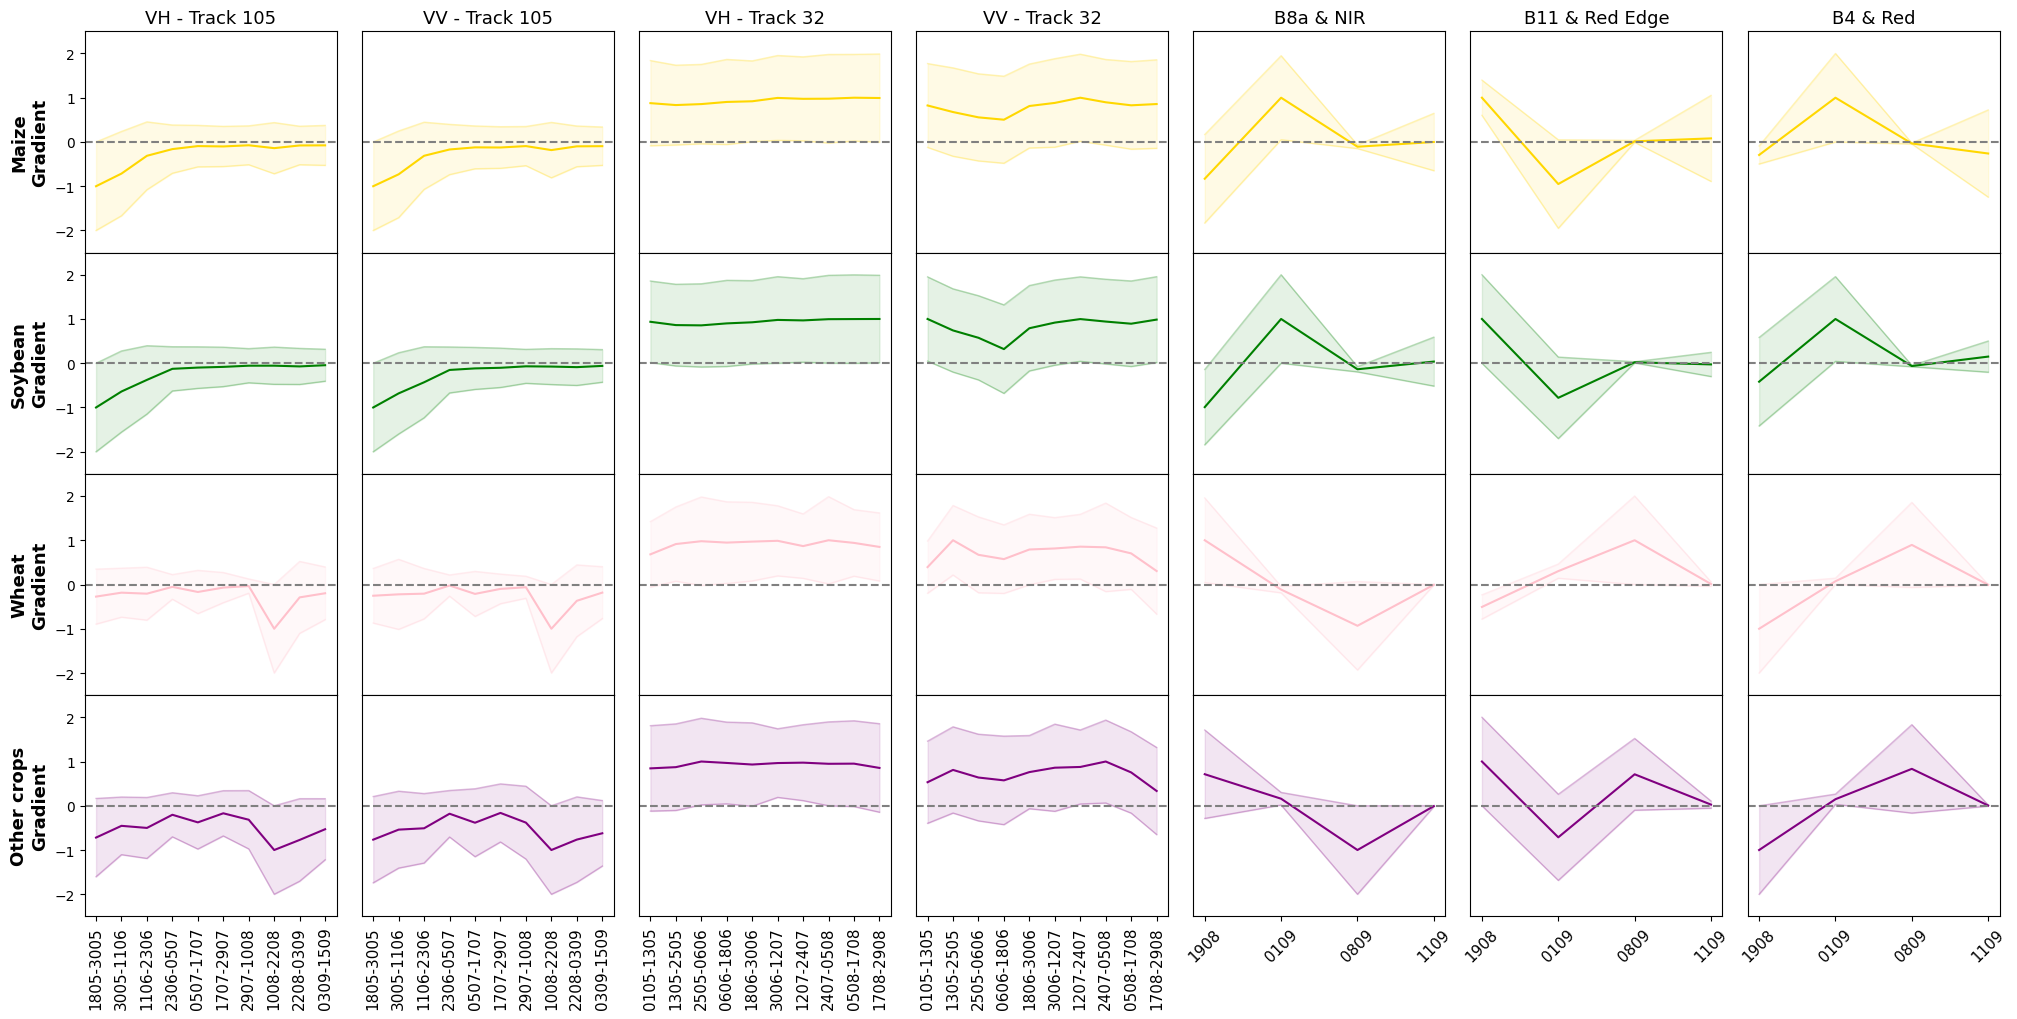

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

# Function to normalize data to the range [-1, 1]
def normalize_to_range(data):
    max_abs_value = np.max(np.abs(data))
    return data / max_abs_value

# 3. Visualization

channels = [
    ("VH - Track 105", all_gradients_1[:, :, 0]),
    ("VV - Track 105", all_gradients_1[:, :, 1]),
    ("VH - Track 32", all_gradients_2[:, :, 0]),
    ("VV - Track 32", all_gradients_2[:, :, 1]),
    ("B8a & NIR", all_gradients_3[:, :, 0]),
    ("B11 & Red Edge", all_gradients_3[:, :, 1]),
    ("B4 & Red", all_gradients_3[:, :, 2])
]

# Assuming the classes are labeled as 1, 2, 3, and 4
unique_classes = [1, 2, 3, 4]



# Define colors for each class
class_colors = {
    1: "gold",
    2: "green",
    3: "pink",
    4: "purple"
}

class_labels = {
    1: "Maize",
    2: "Soybean",
    3: "Wheat",
    4: "Other crops"
}

# Define custom x-ticks
track105 = ["1805-3005","3005-1106","1106-2306", "2306-0507","0507-1707", "1707-2907",
             "2907-1008", "1008-2208", "2208-0309", "0309-1509"]

track32 = ["0105-1305","1305-2505","2505-0606", "0606-1806","1806-3006", "3006-1207",
             "1207-2407", "2407-0508", "0508-1708", "1708-2908"]

optical = ['1908','0109','0809','1109']

# Modifying the code based on the new instructions
fig, axes = plt.subplots(nrows=4, ncols=len(channels), figsize=(20, 10))

for class_idx in unique_classes:
    for col, (channel_name, data) in enumerate(channels):
        class_data = data[selected_labels == class_idx]
        mean_values = np.mean(class_data, axis=0)
        std_values = np.std(class_data, axis=0)

        # Normalize the mean values and standard deviations
        normalized_mean = normalize_to_range(mean_values)
        normalized_std = normalize_to_range(std_values)

        time_steps = np.arange(1, data.shape[1] + 1)
        axes[class_idx - 1, col].plot(time_steps, normalized_mean, color=class_colors[class_idx])
        axes[class_idx - 1, col].fill_between(time_steps, normalized_mean - normalized_std, normalized_mean + normalized_std, color=class_colors[class_idx], alpha=0.1)
        axes[class_idx - 1, col].plot(
            time_steps, normalized_mean - normalized_std,
            linewidth=1, color=class_colors[class_idx], alpha=0.25
        )
        axes[class_idx - 1, col].plot(
            time_steps, normalized_mean + normalized_std,
            linewidth=1, color=class_colors[class_idx], alpha=0.25
        )

        axes[class_idx - 1, col].set_ylim([-2.5, 2.5])

        # Add a horizontal dashed line at y=0
        axes[class_idx - 1, col].axhline(0, linestyle='--', color='gray')

        # Adjusting titles, x-labels, x-ticks based on the provided instructions
        if class_idx == 1:  # Add titles only for the top row (Maize)
            axes[class_idx - 1, col].set_title(f"{channel_name}",fontsize=13)
        if class_idx < 4:
            axes[class_idx - 1, col].set_xticks([])
        else:
            if "Track 105" in channel_name:
                axes[class_idx - 1, col].set_xticks(time_steps)
                axes[class_idx - 1, col].set_xticklabels(track105, rotation=90,fontsize=11)
            elif "Track 32" in channel_name:
                axes[class_idx - 1, col].set_xticks(time_steps)
                axes[class_idx - 1, col].set_xticklabels(track32, rotation=90,fontsize=11)
            else:
                axes[class_idx - 1, col].set_xticks(np.linspace(1, len(optical), len(optical)))
                axes[class_idx - 1, col].set_xticklabels(optical, rotation=45,fontsize=11)

        axes[class_idx - 1, col].set_xlabel("")

        # Only set y-axis labels and y-ticks for the first column
        if col == 0:
            label = class_labels[class_idx] + "\nGradient"
            axes[class_idx - 1, col].set_ylabel(label, weight="bold", fontsize=13)
        else:
            axes[class_idx - 1, col].set_yticks([])
            axes[class_idx - 1, col].set_ylabel("")

plt.tight_layout(pad=0)
plt.subplots_adjust(wspace=0.1, hspace=0)
plt.savefig('gdrive/My Drive/Chapter 5/Plots 2.0/Gradient_Transformer_self_attention_2018_corect_dates.png', dpi=600)

plt.show()

# For gradient of AtLSTM weights with respect to inputs

In [ ]:
# 1. Set up the derivative computation
input_tensor = new_model.input
output_tensor = new_model.output

In [ ]:
intermediate_layer_model = tf.keras.models.Model(inputs=new_model.input, outputs=new_model.get_layer('dense_35').output)


In [ ]:
# Randomly select 3000 samples
random_indices = np.random.choice(1618487, 3000, replace=False)

selected_images_1 = test_images_scaled_1[random_indices]
selected_images_2 = test_images_scaled_2[random_indices]
selected_images_3 = test_images_scaled_3[random_indices]

In [ ]:
selected_labels = test_labels[random_indices]

In [ ]:
# Create an intermediate model to get the attention weights
intermediate_layer_model = tf.keras.models.Model(
    inputs=new_model.input,
    outputs=[
        new_model.get_layer('attention_weight_1').output,
        new_model.get_layer('attention_weight_2').output,
        new_model.get_layer('attention_weight_3').output
    ]
)

all_gradients_1 = []
all_gradients_2 = []
all_gradients_3 = []

for sample_1, sample_2, sample_3 in zip(selected_images_1, selected_images_2, selected_images_3):
    # Convert numpy arrays to TensorFlow tensors
    sample_1_tensor = tf.convert_to_tensor(sample_1)
    sample_2_tensor = tf.convert_to_tensor(sample_2)
    sample_3_tensor = tf.convert_to_tensor(sample_3)

    with tf.GradientTape(persistent=True) as tape:
        tape.watch([sample_1_tensor, sample_2_tensor, sample_3_tensor])

        # Forward pass to get attention weights
        attention_weight_1, attention_weight_2, attention_weight_3 = intermediate_layer_model(
            [sample_1_tensor[None, ...], sample_2_tensor[None, ...], sample_3_tensor[None, ...]]
        )

    # Compute gradients with respect to the second dimension (time steps)
    gradient_1 = tape.gradient(attention_weight_1, sample_1_tensor)
    gradient_2 = tape.gradient(attention_weight_2, sample_2_tensor)
    gradient_3 = tape.gradient(attention_weight_3, sample_3_tensor)

    all_gradients_1.append(gradient_1.numpy())
    all_gradients_2.append(gradient_2.numpy())
    all_gradients_3.append(gradient_3.numpy())

all_gradients_1 = np.array(all_gradients_1)
all_gradients_2 = np.array(all_gradients_2)
all_gradients_3 = np.array(all_gradients_3)

In [ ]:
all_gradients_3 = all_gradients_3[:, [0, 1, 3, 2], :]

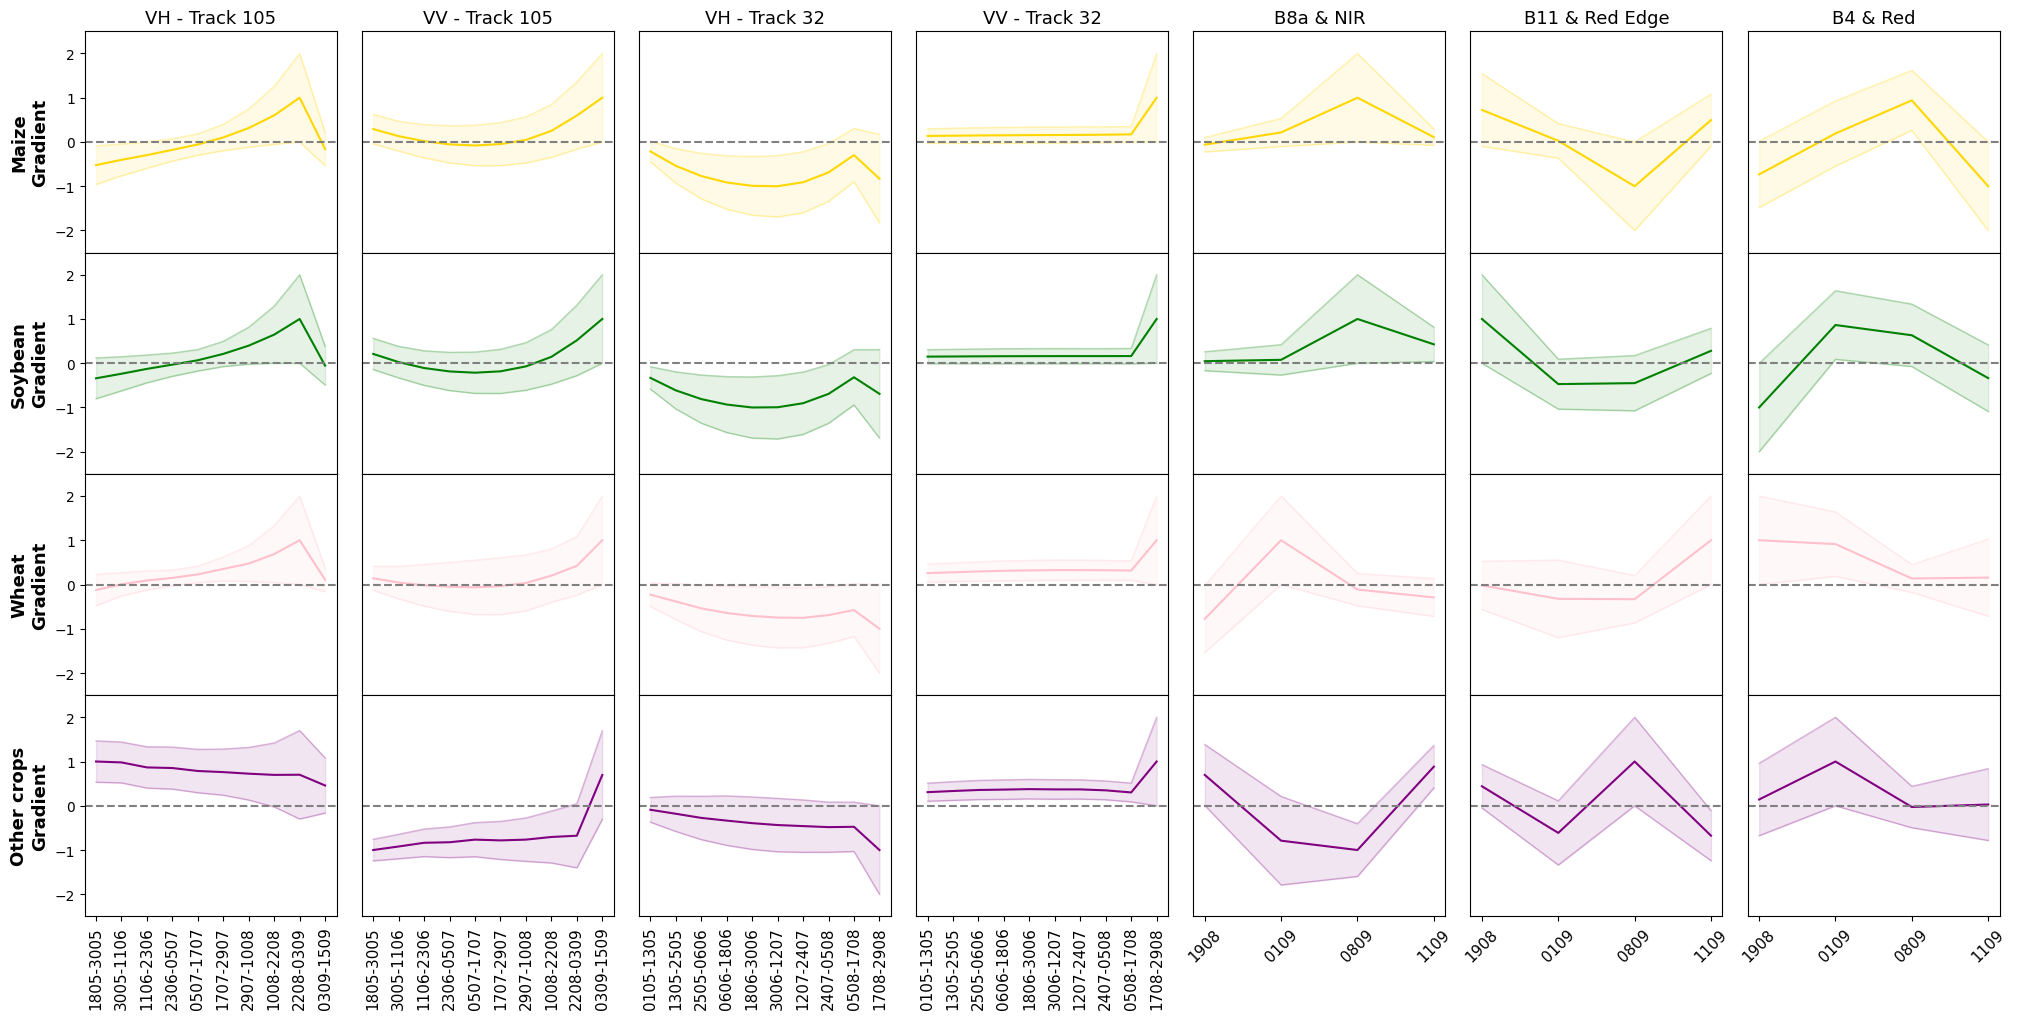

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

# 3. Visualization

channels = [
    ("VH - Track 105", all_gradients_1[:, :, 0]),
    ("VV - Track 105", all_gradients_1[:, :, 1]),
    ("VH - Track 32", all_gradients_2[:, :, 0]),
    ("VV - Track 32", all_gradients_2[:, :, 1]),
    ("B8a & NIR", all_gradients_3[:, :, 0]),
    ("B11 & Red Edge", all_gradients_3[:, :, 1]),
    ("B4 & Red", all_gradients_3[:, :, 2])
]

# Assuming the classes are labeled as 1, 2, 3, and 4
unique_classes = [1, 2, 3, 4]



# Define colors for each class
class_colors = {
    1: "gold",
    2: "green",
    3: "pink",
    4: "purple"
}

class_labels = {
    1: "Maize",
    2: "Soybean",
    3: "Wheat",
    4: "Other crops"
}



# Define custom x-ticks
track105 = ["1805-3005","3005-1106","1106-2306", "2306-0507","0507-1707", "1707-2907",
             "2907-1008", "1008-2208", "2208-0309", "0309-1509"]

track32 = ["0105-1305","1305-2505","2505-0606", "0606-1806","1806-3006", "3006-1207",
             "1207-2407", "2407-0508", "0508-1708", "1708-2908"]

optical = ['1908','0109','0809','1109']

# Modifying the code based on the new instructions
fig, axes = plt.subplots(nrows=4, ncols=len(channels), figsize=(20, 10))

for class_idx in unique_classes:
    for col, (channel_name, data) in enumerate(channels):
        class_data = data[selected_labels == class_idx]
        mean_values = np.mean(class_data, axis=0)
        std_values = np.std(class_data, axis=0)

        # Normalize the mean values and standard deviations
        normalized_mean = normalize_to_range(mean_values)
        normalized_std = normalize_to_range(std_values)

        time_steps = np.arange(1, data.shape[1] + 1)
        axes[class_idx - 1, col].plot(time_steps, normalized_mean, color=class_colors[class_idx])
        axes[class_idx - 1, col].fill_between(time_steps, normalized_mean - normalized_std, normalized_mean + normalized_std, color=class_colors[class_idx], alpha=0.1)
        axes[class_idx - 1, col].plot(
            time_steps, normalized_mean - normalized_std,
            linewidth=1, color=class_colors[class_idx], alpha=0.25
        )
        axes[class_idx - 1, col].plot(
            time_steps, normalized_mean + normalized_std,
            linewidth=1, color=class_colors[class_idx], alpha=0.25
        )

        axes[class_idx - 1, col].set_ylim([-2.5, 2.5])

        # Add a horizontal dashed line at y=0
        axes[class_idx - 1, col].axhline(0, linestyle='--', color='gray')

        # Adjusting titles, x-labels, x-ticks based on the provided instructions
        if class_idx == 1:  # Add titles only for the top row (Maize)
            axes[class_idx - 1, col].set_title(f"{channel_name}",fontsize=13)
        if class_idx < 4:
            axes[class_idx - 1, col].set_xticks([])
        else:
            if "Track 105" in channel_name:
                axes[class_idx - 1, col].set_xticks(time_steps)
                axes[class_idx - 1, col].set_xticklabels(track105, rotation=90,fontsize=11)
            elif "Track 32" in channel_name:
                axes[class_idx - 1, col].set_xticks(time_steps)
                axes[class_idx - 1, col].set_xticklabels(track32, rotation=90,fontsize=11)
            else:
                axes[class_idx - 1, col].set_xticks(np.linspace(1, len(optical), len(optical)))
                axes[class_idx - 1, col].set_xticklabels(optical, rotation=45,fontsize=11)

        axes[class_idx - 1, col].set_xlabel("")

        # Only set y-axis labels and y-ticks for the first column
        if col == 0:
            label = class_labels[class_idx] + "\nGradient"
            axes[class_idx - 1, col].set_ylabel(label, weight="bold", fontsize=13)
        else:
            axes[class_idx - 1, col].set_yticks([])
            axes[class_idx - 1, col].set_ylabel("")

plt.tight_layout(pad=0)
plt.subplots_adjust(wspace=0.1, hspace=0)
plt.savefig('gdrive/My Drive/Chapter 5/Plots 2.0/Gradient_Transformer+atlstm_2018_correct_order2_correct_dates.png', dpi=600)

plt.show()